In [1]:
%cd /qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1

/qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1


In [2]:
import numpy as np
import pickle
from sklearn import decomposition
from scipy.stats import spearmanr
from functools import reduce
import matplotlib.ticker as ticker
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO
import matplotlib.colors as mcolors
import pylab as pl
from collections import Counter
from matplotlib import colors as colors

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_style("whitegrid")

# fig.patch.set_facecolor('white')
%matplotlib inline

In [3]:
trgenename = pd.read_csv('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/references/Mouse-SCV2.transcript-genenames.txt', sep='\t', names=['transcript_id', 'gene_name'], index_col=0)
codinglengths = pd.read_csv('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/references/transcript-coding-lengths.txt', sep='\t',
                            names='transcript_id gene_id utr5 cds utr3 noncoding'.split())

repisoform = pickle.load(open('/qbio/junsoopablo//02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/representative-isoforms.pickle','rb'))


codinglengths['genesize'] = codinglengths['utr5'] + codinglengths['cds'] + codinglengths['utr3']
codinglengths_gene = pd.merge(codinglengths, trgenename, how='inner', left_on='transcript_id', right_index=True)
codinglengths_gene = codinglengths_gene.loc[codinglengths_gene['transcript_id'].isin(repisoform['transcript_id'])]

cdslen_dic = codinglengths_gene.set_index('transcript_id')['cds'].to_dict()
utr3len_dic = codinglengths_gene.set_index('transcript_id')['utr3'].to_dict()
gene_dic = codinglengths_gene.copy(deep=True)
gene_dic['gene_id'] = gene_dic['gene_id'].str.split('.',expand=True)[0]
gene_dic = gene_dic.set_index('transcript_id')['gene_id'].to_dict()

genelen_dic = codinglengths_gene.set_index('transcript_id')['genesize'].to_dict()
genesym_dic = codinglengths_gene[['gene_id', 'gene_name']]
genesym_dic['gene_id'] = genesym_dic['gene_id'].str.split('.',expand=True)[0]
genesym_dic = genesym_dic.set_index('gene_id')['gene_name'].to_dict()


codinglengths_gene.head()

/tmp/ipykernel_1085848/1395101429.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genesym_dic['gene_id'] = genesym_dic['gene_id'].str.split('.',expand=True)[0]


,transcript_id,gene_id,utr5,cds,utr3,noncoding,genesize,gene_name
0,ENSMUST00000000001.5,ENSMUSG00000000001.5,141,1065,2056,0,3262,Gnai3
1,ENSMUST00000000003.14,ENSMUSG00000000003.16,140,525,237,0,902,Pbsn
2,ENSMUST00000000010.9,ENSMUSG00000020875.10,85,753,1736,0,2574,Hoxb9
3,ENSMUST00000000028.14,ENSMUSG00000000028.16,313,1701,129,0,2143,Cdc45
5,ENSMUST00000000049.6,ENSMUSG00000000049.12,51,1038,101,0,1190,Apoh


In [4]:
codinglengths_gene.loc[codinglengths_gene['gene_name']=='Rpl26']

,transcript_id,gene_id,utr5,cds,utr3,noncoding,genesize,gene_name
75713,ENSMUST00000167436.3,ENSMUSG00000060938.15,128,438,40,0,606,Rpl26


# Convert genome bam to transcript bam

In [5]:
# ! java -jar /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/contrib/ubu.jar \
#     sam-xlate --bed /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12 \
#         --in filtered-RPF-siLuc.bam --out filtered-RPF-siLuc_transcriptome_tmp.bam --single --reverse
# ! samtools view -h filtered-RPF-siLuc_transcriptome_tmp.bam | \
#         awk -vOFS='\t' '/^@/ { print $0; } \
#         /^[^@]/ { $2 = xor($2, 8); print }' | \
#     samtools sort -@ 10 --write-index -o filtered-RPF-siLuc_transcriptome.bam -

In [6]:
# ! java -jar /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/contrib/ubu.jar \
#     sam-xlate --bed /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12 \
#         --in filtered-RPF-siLin28a.bam --out filtered-RPF-siLin28a_transcriptome_tmp.bam --single --reverse
# ! samtools view -h filtered-RPF-siLin28a_transcriptome_tmp.bam | \
#         awk -vOFS='\t' '/^@/ { print $0; } \
#         /^[^@]/ { $2 = xor($2, 8); print }' | \
#     samtools sort -@ 10 --write-index -o filtered-RPF-siLin28a_transcriptome.bam -

# convert bam to rpf counts

In [ ]:
# !bedtools genomecov -ibam filtered-RPF-siLuc_transcriptome.bam -bg -5 > siLuc_transcriptome.bed
# !head siLuc_transcriptome.bed

ENSMUST00000018875.13	199	200	1
ENSMUST00000018875.13	201	202	1
ENSMUST00000018875.13	224	225	1
ENSMUST00000018875.13	233	234	16
ENSMUST00000018875.13	234	235	5
ENSMUST00000018875.13	236	238	2
ENSMUST00000018875.13	238	239	1
ENSMUST00000018875.13	240	241	1
ENSMUST00000018875.13	247	248	1
ENSMUST00000018875.13	249	250	3


In [ ]:
# !bedtools genomecov -ibam filtered-RPF-siLin28a_transcriptome.bam -bg -5 > siLin28a_transcriptome.bed
# !head siLin28a_transcriptome.bed

ENSMUST00000018875.13	202	203	1
ENSMUST00000018875.13	220	221	1
ENSMUST00000018875.13	223	224	2
ENSMUST00000018875.13	226	227	1
ENSMUST00000018875.13	233	235	2
ENSMUST00000018875.13	247	248	1
ENSMUST00000018875.13	255	256	1
ENSMUST00000018875.13	256	257	2
ENSMUST00000018875.13	258	261	1
ENSMUST00000018875.13	273	274	1


# Identify transmembrane segments

In [7]:
protstbl = pickle.load(open('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/analysis/rpf-function/uniprot-localization-tags.pickle', 'rb'))
uniprot_ensgene_map = pickle.load(open('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/analysis/rpf-function/uniprot-ensembl-mapping.pickle', 'rb'))
protstbl = pd.merge(protstbl,uniprot_ensgene_map, left_on='ID', right_on='uniprot_id')
protstbl

,ID,topology,length,annotags,subcellular location,tissue specificity,tail-anchored,Apical cell membrane,Basolateral cell membrane,Cell junction,...,have-nterm-signal,have-signal,have-subcellular-location,nterm-cytoplasmic,nterm-extracellular,nterm-lumenal,nterm-mitochondrial intermembrane,nterm-mitochondrial matrix,uniprot_id,ensembl_gene_id
0,A0A075B5J2_MOUSE,"{'SIGNAL': [(0, 15, {'evidence': 'ECO:0000256|...",110,"{have-nterm-signal, have-signal}",NaN,NaN,False,False,False,False,...,True,True,False,False,False,False,False,False,A0A075B5J2_MOUSE,ENSMUSG00000076481
1,A0A0A6YYE5_MOUSE,"{'SIGNAL': [(0, 22, {'evidence': 'ECO:0000256|...",119,"{have-nterm-signal, have-signal}",NaN,NaN,False,False,False,False,...,True,True,False,False,False,False,False,False,A0A0A6YYE5_MOUSE,ENSMUSG00000094315
2,A0A1B0GT27_MOUSE,NaN,204,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A1B0GT27_MOUSE,ENSMUSG00000108348
3,A0A1B0GT39_MOUSE,NaN,78,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A1B0GT39_MOUSE,ENSMUSG00000109833
4,A0A286YDL3_MOUSE,NaN,209,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A286YDL3_MOUSE,ENSMUSG00000099655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31890,TSLP_MOUSE,"{'SIGNAL': [(0, 19, {'evidence': 'ECO:0000255'...",140,"{Secreted, have-nterm-signal, have-signal, hav...","[(Secreted, [ECO:0000269|PubMed:10974033])]",NaN,False,False,False,False,...,True,True,True,False,False,False,False,False,TSLP_MOUSE,ENSMUSG00000024379
31891,SERC3_MOUSE,"{'TOPO_DOM': [(0, 96, {'note': 'Extracellular'...",472,"{nterm-extracellular, have-subcellular-locatio...","[(Cell membrane, [ECO:0000269|PubMed:12486168]...",Highly expressed in the neuronal populations s...,False,False,False,False,...,False,False,True,False,True,False,False,False,SERC3_MOUSE,ENSMUSG00000017707
31892,SAE1_MOUSE,NaN,350,"{Nucleus, have-subcellular-location}","[(Nucleus, [ECO:0000250])]","Broadly expressed, with highest levels in test...",False,False,False,False,...,False,False,True,False,False,False,False,False,SAE1_MOUSE,ENSMUSG00000052833
31893,SAE1_MOUSE,NaN,350,"{Nucleus, have-subcellular-location}","[(Nucleus, [ECO:0000250])]","Broadly expressed, with highest levels in test...",False,False,False,False,...,False,False,True,False,False,False,False,False,SAE1_MOUSE,ENSMUSG00000052833


In [8]:
signal_genes = protstbl.loc[protstbl['have-signal']==True]
signal_genes = signal_genes['ensembl_gene_id'].to_list()

tail_genes = protstbl.loc[protstbl['tail-anchored']==True]
tail_genes = tail_genes['ensembl_gene_id'].to_list()

multi_genes = protstbl.loc[protstbl['Multi-pass membrane protein']==True]
single_genes = protstbl.loc[protstbl['Single-pass membrane protein']==True]

multi_genes = multi_genes['ensembl_gene_id'].to_list()
single_genes = single_genes['ensembl_gene_id'].to_list()
transmem_dic = {'multi':multi_genes, 'single':single_genes}
transmem_dic = {k: oldk for oldk, oldv in transmem_dic.items() for k in oldv}


In [16]:
membrane_prot = protstbl.loc[(protstbl['Single-pass membrane protein']==True) | (protstbl['Multi-pass membrane protein']==True)]
#['ensembl_gene_id'].unique()
membrane_prot = membrane_prot[['ensembl_gene_id','topology']]
membrane_prot['transmembrane1'] = membrane_prot['topology'].apply(lambda x: x.get('TRANSMEM') if isinstance(x, dict)==True else '')
membrane_prot['transmembrane'] = membrane_prot['transmembrane1'].apply(lambda x: [(i[0]*3,i[1]*3+3) for i in x] if isinstance(x, list)==True else '')
membrane_prot = membrane_prot.loc[membrane_prot['transmembrane']!='']
membrane_prot

,ensembl_gene_id,topology,transmembrane1,transmembrane
7,ENSMUSG00000078599,"{'SIGNAL': [(0, 25, {'evidence': 'ECO:0000255'...","[(244, 265, {'note': 'Helical', 'evidence': 'E...","[(732, 798), (864, 930), (993, 1059)]"
30,ENSMUSG00000091682,"{'TRANSMEM': [(137, 160, {'note': 'Helical', '...","[(137, 160, {'note': 'Helical', 'evidence': 'E...","[(411, 483)]"
39,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
40,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
41,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
...,...,...,...,...
31869,ENSMUSG00000035559,"{'TRANSMEM': [(23, 40, {'note': 'Helical', 'ev...","[(23, 40, {'note': 'Helical', 'evidence': 'ECO...","[(69, 123), (186, 252), (303, 369)]"
31873,ENSMUSG00000021432,"{'TRANSMEM': [(45, 66, {'note': 'Helical', 'ev...","[(45, 66, {'note': 'Helical', 'evidence': 'ECO...","[(135, 201), (234, 300), (342, 408), (411, 477..."
31874,ENSMUSG00000021432,"{'TRANSMEM': [(45, 66, {'note': 'Helical', 'ev...","[(45, 66, {'note': 'Helical', 'evidence': 'ECO...","[(135, 201), (234, 300), (342, 408), (411, 477..."
31886,ENSMUSG00000064158,"{'SIGNAL': [(0, 21, {'evidence': 'ECO:0000255'...","[(319, 340, {'note': 'Helical', 'evidence': 'E...","[(957, 1023)]"


In [17]:
def select_signal(row):
    if row==None: return None
    if row[0][1]==None: return None
    else:
        return [row[0][0]*3, row[0][1]*3]

In [18]:
def transmem_region(df, genecol):
    return (np.where(df[genecol].isin(tail_genes), 'Tail-anchored',
                    np.where(df[genecol].isin(multi_genes), 'Multi-pass',
                            np.where(df[genecol].isin(signal_genes), 'N-term signal',
                                    np.where(df[genecol].isin(single_genes), 'No N-term signal', 'Non-ER-associated')))))

In [19]:
membrane_prot['signalpeptide1'] = membrane_prot['topology'].apply(lambda x: x.get('SIGNAL') if isinstance(x, dict)==True else '')
membrane_prot['signalpeptide'] = membrane_prot['signalpeptide1'].apply(lambda x: select_signal(x))
membrane_prot = membrane_prot.drop(columns=['transmembrane1','signalpeptide1','topology'])
membrane_prot['transtype'] = transmem_region(membrane_prot, 'ensembl_gene_id')
membrane_prot

,ensembl_gene_id,transmembrane,signalpeptide,transtype
7,ENSMUSG00000078599,"[(732, 798), (864, 930), (993, 1059)]","[0, 75]",Multi-pass
30,ENSMUSG00000091682,"[(411, 483)]",None,Tail-anchored
39,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
40,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
41,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
...,...,...,...,...
31869,ENSMUSG00000035559,"[(69, 123), (186, 252), (303, 369)]",None,Multi-pass
31873,ENSMUSG00000021432,"[(135, 201), (234, 300), (342, 408), (411, 477...",None,Multi-pass
31874,ENSMUSG00000021432,"[(135, 201), (234, 300), (342, 408), (411, 477...",None,Multi-pass
31886,ENSMUSG00000064158,"[(957, 1023)]","[0, 63]",N-term signal


In [22]:
nsignal_prot_dic = membrane_prot.loc[(membrane_prot['transtype']=='N-term signal') & (membrane_prot['signalpeptide']!='None')]
# signal_prot['signalpeptide'] = signal_prot['signalpeptide'].astype('list')
nsignal_prot_dic = nsignal_prot_dic[['ensembl_gene_id','signalpeptide']]
nsignal_prot_dic.set_index('ensembl_gene_id', inplace=True)
nsignal_prot_dic = nsignal_prot_dic.to_dict()['signalpeptide']
nsignal_prot_dic

{'ENSMUSG00000037157': [0, 45],
 'ENSMUSG00000103567': [0, 72],
 'ENSMUSG00000055471': [0, 54],
 'ENSMUSG00000029377': [0, 66],
 'ENSMUSG00000026442': [0, 72],
 'ENSMUSG00000039156': [0, 42],
 'ENSMUSG00000020717': [0, 51],
 'ENSMUSG00000048234': [0, 93],
 'ENSMUSG00000045631': [0, 54],
 'ENSMUSG00000063900': [0, 66],
 'ENSMUSG00000030281': [0, 63],
 'ENSMUSG00000060548': [0, 87],
 'ENSMUSG00000036503': [0, 102],
 'ENSMUSG00000040680': [0, 72],
 'ENSMUSG00000009291': [0, 87],
 'ENSMUSG00000025652': [0, 66],
 'ENSMUSG00000053216': [0, 87],
 'ENSMUSG00000040522': [0, 69],
 'ENSMUSG00000058398': [0, 81],
 'ENSMUSG00000007440': [0, 90],
 'ENSMUSG00000021991': [0, 99],
 'ENSMUSG00000079491': [0, 57],
 'ENSMUSG00000040118': [0, 72],
 'ENSMUSG00000103458': [0, 87],
 'ENSMUSG00000104252': [0, 87],
 'ENSMUSG00000028226': [0, 93],
 'ENSMUSG00000045589': [0, 84],
 'ENSMUSG00000001029': [0, 66],
 'ENSMUSG00000028664': [0, 54],
 'ENSMUSG00000032336': [0, 84],
 'ENSMUSG00000046480': [0, 90],
 'ENSMU

In [24]:
membrane_prot['transmembrane'] = membrane_prot['transmembrane'].astype(str)
membrane_prot['signalpeptide'] = membrane_prot['signalpeptide'].astype(str)

membrane_prot = membrane_prot.drop_duplicates()
membrane_prot = membrane_prot.loc[membrane_prot['transmembrane']!='']
membrane_prot.head()

,ensembl_gene_id,transmembrane,signalpeptide,transtype
7,ENSMUSG00000078599,"[(732, 798), (864, 930), (993, 1059)]","[0, 75]",Multi-pass
30,ENSMUSG00000091682,"[(411, 483)]",None,Tail-anchored
39,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
63,ENSMUSG00000042793,"[(1701, 1767), (1794, 1860), (1932, 1998), (20...","[0, 66]",Multi-pass
68,ENSMUSG00000026904,"[(1527, 1593), (1614, 1680), (1686, 1752), (17...",None,Multi-pass


In [25]:
import ast
from collections import defaultdict
membrane_dic = defaultdict(list)
membrane_list = []
for i in membrane_prot.index:
    gene = membrane_prot.loc[i,'ensembl_gene_id']
    trans = membrane_prot.loc[i,'transmembrane']
    trans = ast.literal_eval(trans)
    region = trans[0]
    membrane_dic[gene] += list(range(region[0],region[1]))
    membrane_list.append(region[1]-region[0]+1)
    # for region in trans:
    #     membrane_dic[gene] += list(range(region[0],region[1]))
    #     membrane_list.append(region[1]-region[0]+1)

In [26]:
import ast
from collections import defaultdict

Dist = 150
peakmid_dic = defaultdict(list)
for i in membrane_prot.index:
    gene = membrane_prot.loc[i,'ensembl_gene_id']
    trans = membrane_prot.loc[i,'transmembrane']
    trans = ast.literal_eval(trans)

    peakmid_dic[gene]
    region = trans[0]
    # for region in trans:
    midsite = int((region[1]+region[0])/2) 
    if midsite > Dist:
        peakmid_dic[gene] += [midsite]

peakmid_dic = {k:v for k,v in peakmid_dic.items() if len(v)>0}

# Select highly expressing genes

In [27]:
def select_highly_expressing_genes(file):
    rpf_all = pd.read_csv(file, sep='\t', names=['transcript_id','start','end','count'])
    # select representative isoforms
    rpf_all = pd.merge(rpf_all, codinglengths_gene, on='transcript_id', how='inner')
    rpf_all['reltostart-asite'] = rpf_all['start'] - rpf_all['utr5'] + 18
    rpf_all = rpf_all.loc[rpf_all['reltostart-asite']>0]
    # select highly expressing genes
    rpf = rpf_all.groupby(['gene_name','transcript_id']).sum().sort_values(by='count', ascending=False)[['count']].reset_index()
    total_read = rpf['count'].sum()
    rpf['rpm'] = rpf['count']/total_read * 10e5
    high_rpf = rpf.loc[rpf['rpm']>=1].copy()
    high_rpf = rpf_all.loc[rpf_all['transcript_id'].isin(high_rpf['transcript_id'])].copy()
    high_rpf['gene_id'] = high_rpf['gene_id'].str.split('.',expand=True)[0]
    high_rpf['rpm'] = high_rpf['count']/total_read * 10e5
    high_rpf = high_rpf[['gene_name','gene_id','transcript_id','reltostart-asite','rpm']]
    return high_rpf


In [84]:
def get_transmem_dist(df, Dist):
    df = df.loc[df['gene_id'].isin(peakmid_dic.keys())].copy()
    df['dist_from_center'] = df.apply(lambda y: min(peakmid_dic.get(y['gene_id']), key=lambda x:abs(x-y['reltostart-asite'])) - y['reltostart-asite'] if (y['gene_id'] in peakmid_dic.keys()) else None, axis=1)
    df = df.loc[abs(df['dist_from_center'])<Dist]
    df['region'] = np.where(df['dist_from_center'].isin(range(-70,71)), 'TMD',
                                        np.where(df['dist_from_center']>0, 'Downstream', 'Upstream'))
    return df


In [85]:
def trans_typing(df, ratio=True):
    df['trans_type'] = np.where(df['gene_id'].isin(tail_genes), 'Tail-anchored',
                                            np.where(df['gene_id'].isin(multi_genes), 'Multi-pass',
                                                    np.where(df['gene_id'].isin(signal_genes), 'N-term signal',
                                                            np.where(df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))
    df_ratio = df.groupby(['gene_id','trans_type','region']).sum()['rpm']
    df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
    if ratio==True:
        df_ratio = df_ratio / df_ratio.sum(level='gene_id')
        df_ratio = df_ratio.to_frame(name='ratio').reset_index()
        return(df_ratio)
    else:
        df_ratio = df_ratio.to_frame(name='rpm').reset_index()
        return(df_ratio)

# Reproduce Figure5D

In [86]:
siLuc_df= select_highly_expressing_genes('siLuc_transcriptome.bed')
# siLuc_df['region'] = transmem_region(siLuc_df)
siLuc_df = siLuc_df.groupby(['gene_id']).sum()[['rpm']]

siLin28a_df= select_highly_expressing_genes('siLin28a_transcriptome.bed')
siLin28a_df = siLin28a_df.groupby(['gene_id']).sum()[['rpm']]
siLin28a_df.head()

# siLin28a_df = select_highly_expressing_genes('siLin28a_transcriptome.bed')
# siLin28a_df = siLin28a_df.groupby(['gene_id']).sum()[['rpm']]

# siLuc_df['trans_type'] = np.where(siLuc_df['gene_id'].isin(tail_genes), 'Tail-anchored',
#                                             np.where(siLuc_df['gene_id'].isin(multi_genes), 'Multi-pass',
#                                                     np.where(siLuc_df['gene_id'].isin(signal_genes), 'N-term signal',
#                                                             np.where(siLuc_df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))


,rpm
gene_id,
ENSMUSG00000000037,1.273534
ENSMUSG00000000056,8.348723
ENSMUSG00000000078,6.862933
ENSMUSG00000000085,1.981053
ENSMUSG00000000088,285.413125


In [87]:
merge_df = pd.merge(siLuc_df, siLin28a_df, on='gene_id', how='inner', suffixes=('_siLuc', '_siLin28a'))
merge_df['ratio'] = merge_df['rpm_siLin28a'] / merge_df['rpm_siLuc']
merge_df['log2ratio'] = np.log2(merge_df['ratio'])
merge_df.reset_index(inplace=True)
merge_df['region'] = transmem_region(merge_df, 'gene_id')
merge_df

,gene_id,rpm_siLuc,rpm_siLin28a,ratio,log2ratio,region
0,ENSMUSG00000000037,4.455444,1.273534,0.285838,-1.806732,Non-ER-associated
1,ENSMUSG00000000056,8.159367,8.348723,1.023207,0.033098,Non-ER-associated
2,ENSMUSG00000000078,6.226886,6.862933,1.102145,0.140315,Non-ER-associated
3,ENSMUSG00000000085,2.791363,1.981053,0.709708,-0.494702,Non-ER-associated
4,ENSMUSG00000000088,198.455142,285.413125,1.438175,0.524239,Non-ER-associated
...,...,...,...,...,...,...
9121,ENSMUSG00000119895,415.054140,777.917033,1.874254,0.906317,Non-ER-associated
9122,ENSMUSG00000119899,26.947385,22.074590,0.819174,-0.287759,Non-ER-associated
9123,ENSMUSG00000119938,20.505779,14.221130,0.693518,-0.527994,Non-ER-associated
9124,ENSMUSG00001118661,11.219130,10.683535,0.952261,-0.070572,Non-ER-associated


[Text(0, 0, 'Non-ER-associated'),
 Text(1, 0, 'Tail-anchored'),
 Text(2, 0, 'No N-term signal'),
 Text(3, 0, 'N-term signal'),
 Text(4, 0, 'Multi-pass')]

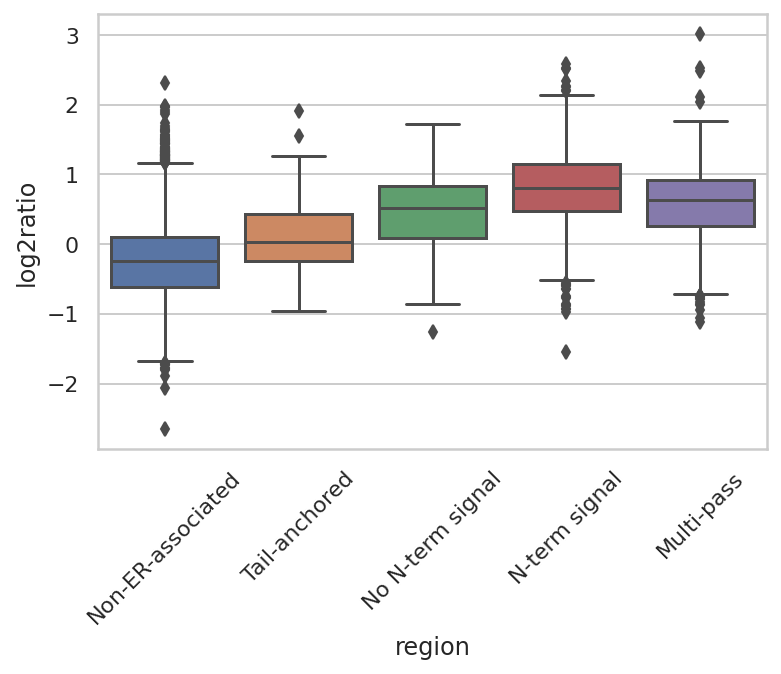

In [88]:
sns.set_style("whitegrid")

g = sns.boxplot(data=merge_df, x='region', y='log2ratio', order=['Non-ER-associated','Tail-anchored','No N-term signal','N-term signal','Multi-pass'])
g.set_xticklabels(g.get_xticklabels(), rotation=45)


# Test if ribosome stall at N-term signal

In [89]:
siLuc_df = select_highly_expressing_genes('siLuc_transcriptome.bed')
siLin28a_df= select_highly_expressing_genes('siLin28a_transcriptome.bed')


In [90]:
siLin28a_df_genes = siLin28a_df.groupby(['gene_id']).sum()['rpm'].to_dict()
siLuc_df_genes = siLuc_df.groupby(['gene_id']).sum()['rpm'].to_dict()

In [91]:
siLin28a_df['rpm_ratio'] = siLin28a_df.apply(lambda x: x['rpm'] / siLin28a_df_genes[x['gene_id']] * 100, axis=1)
siLuc_df['rpm_ratio'] = siLuc_df.apply(lambda x: x['rpm'] / siLuc_df_genes[x['gene_id']] * 100, axis=1)

siLin28a_df['cds_len'] = siLin28a_df['transcript_id'].map(cdslen_dic)
siLuc_df['cds_len'] = siLuc_df['transcript_id'].map(cdslen_dic)
siLin28a_df

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,rpm_ratio,cds_len
26,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,1,0.070752,0.118483,2856
27,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,5,0.141504,0.236967,2856
28,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,6,0.070752,0.118483,2856
29,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,9,0.212256,0.355450,2856
30,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,11,0.070752,0.118483,2856
...,...,...,...,...,...,...,...
1306164,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1530,0.070752,0.552486,1758
1306165,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,2034,0.070752,0.552486,1758
1306166,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,3188,0.070752,0.552486,1758
1306167,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,3757,0.070752,0.552486,1758


In [92]:
siLuc_df['signaldist'] = siLuc_df.apply(lambda x: x['reltostart-asite'] - nsignal_prot_dic[x['gene_id']][1] if x['gene_id'] in nsignal_prot_dic.keys() else None, axis=1)
siLin28a_df['signaldist'] = siLin28a_df.apply(lambda x: x['reltostart-asite'] - nsignal_prot_dic[x['gene_id']][1] if x['gene_id'] in nsignal_prot_dic.keys() else None, axis=1)

siLuc_df['signaldist_group'] = np.where(siLuc_df['signaldist'] <=0, True, False)
siLin28a_df['signaldist_group'] = np.where(siLin28a_df['signaldist'] <=0, True, False)

siLuc_df = siLuc_df.loc[siLuc_df['signaldist'].notnull()]
siLin28a_df = siLin28a_df.loc[siLin28a_df['signaldist'].notnull()]


siLin28a_df

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,rpm_ratio,cds_len,signaldist,signaldist_group
6973,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,230,0.141504,11.764706,1185,143.0,False
6974,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,285,0.070752,5.882353,1185,198.0,False
6975,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,525,0.070752,5.882353,1185,438.0,False
6976,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,690,0.070752,5.882353,1185,603.0,False
6977,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,717,0.070752,5.882353,1185,630.0,False
...,...,...,...,...,...,...,...,...,...
1298581,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2487,0.070752,1.075269,2796,2412.0,False
1298582,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2543,0.070752,1.075269,2796,2468.0,False
1298583,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2643,0.070752,1.075269,2796,2568.0,False
1298584,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2720,0.070752,1.075269,2796,2645.0,False


In [93]:
siLuc_ratio = siLuc_df.groupby(['gene_id','signaldist_group']).sum()[['rpm_ratio']].reset_index()
siLin28a_ratio = siLin28a_df.groupby(['gene_id','signaldist_group']).sum()[['rpm_ratio']].reset_index()
siLuc_ratio.set_index(['gene_id','signaldist_group'], inplace=True)
siLin28a_ratio.set_index(['gene_id','signaldist_group'], inplace=True)
siLuc_ratio = siLuc_ratio.reindex(pd.MultiIndex.from_product([siLuc_ratio.index.get_level_values('gene_id'), [True, False]], names=['gene_id','signaldist_group'])).fillna(0).reset_index()
siLin28a_ratio = siLin28a_ratio.reindex(pd.MultiIndex.from_product([siLin28a_ratio.index.get_level_values('gene_id'), [True, False]], names=['gene_id','signaldist_group'])).fillna(0).reset_index()
merge_ratio = pd.merge(siLuc_ratio, siLin28a_ratio, on=['gene_id','signaldist_group'], how='inner', suffixes=('_siLuc', '_siLin28a'))
merge_ratio = merge_ratio.groupby('signaldist_group').mean()
merge_ratio

,rpm_ratio_siLuc,rpm_ratio_siLin28a
signaldist_group,,
False,94.816287,95.246035
True,5.183713,4.753965


In [94]:
target_range = range(-50,51)
siLin28a_signal = siLin28a_df.loc[siLin28a_df['signaldist'].isin(target_range)]
siLuc_signal = siLuc_df.loc[siLuc_df['signaldist'].isin(target_range)]

siLin28a_signal = siLin28a_signal[['transcript_id','signaldist','rpm_ratio']].set_index(['transcript_id','signaldist'])
siLuc_signal = siLuc_signal[['transcript_id','signaldist','rpm_ratio']].set_index(['transcript_id','signaldist'])

siLuc_signal = siLuc_signal.reindex(pd.MultiIndex.from_product([siLuc_signal.index.get_level_values('transcript_id'),target_range], names=['transcript_id','signaldist'])).fillna(0)
siLin28a_signal = siLin28a_signal.reindex(pd.MultiIndex.from_product([siLin28a_signal.index.get_level_values('transcript_id'),target_range], names=['transcript_id','signaldist'])).fillna(0)
siLuc_signal

rpm_ratio
transcript_id         signaldist           
ENSMUST00000002011.14 -50               0.0
                      -49               0.0
                      -48               0.0
                      -47               0.0
                      -46               0.0
...                                     ...
ENSMUST00000090821.10  46               0.0
                       47               0.0
                       48               0.0
                       49               0.0
                       50               0.0

[269064 rows x 1 columns]

Text(0.5, 0, "Distance from 3'end of signal peptide")

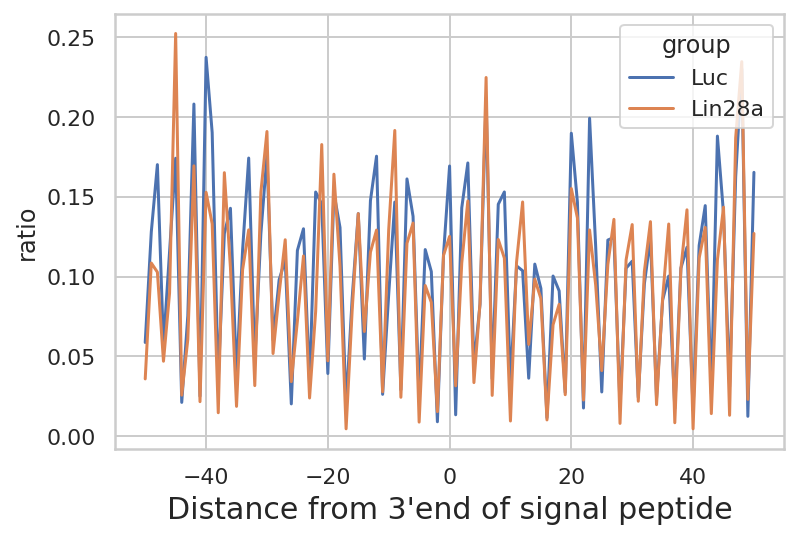

In [95]:
siLuc_signal = siLuc_signal.groupby('signaldist').mean()[['rpm_ratio']]
siLin28a_signal = siLin28a_signal.groupby('signaldist').mean()[['rpm_ratio']]

signal_merge = pd.merge(siLuc_signal, siLin28a_signal, on='signaldist', how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
signal_merge.columns = ['signaldist','group','ratio']
signal_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['Luc','Lin28a'], inplace=True)
g = sns.lineplot(data=signal_merge, x='signaldist', y='ratio', hue='group')
g.set_xlabel("Distance from 3'end of signal peptide", fontsize=15)

# Test if rpf ratio decrease at stop codon site

In [96]:
siLin28a_df['reltostop-asite'] = siLin28a_df.apply(lambda x: x['reltostart-asite'] - cdslen_dic[x['transcript_id']], axis=1)
siLuc_df['reltostop-asite'] = siLuc_df.apply(lambda x: x['reltostart-asite'] - cdslen_dic[x['transcript_id']], axis=1)

siLin28a_df

/tmp/ipykernel_1085848/192673905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  siLin28a_df['reltostop-asite'] = siLin28a_df.apply(lambda x: x['reltostart-asite'] - cdslen_dic[x['transcript_id']], axis=1)


,gene_name,gene_id,transcript_id,reltostart-asite,rpm,rpm_ratio,cds_len,signaldist,signaldist_group,reltostop-asite
6973,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,230,0.141504,11.764706,1185,143.0,False,-955
6974,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,285,0.070752,5.882353,1185,198.0,False,-900
6975,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,525,0.070752,5.882353,1185,438.0,False,-660
6976,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,690,0.070752,5.882353,1185,603.0,False,-495
6977,Esam,ENSMUSG00000001946,ENSMUST00000002011.14,717,0.070752,5.882353,1185,630.0,False,-468
...,...,...,...,...,...,...,...,...,...,...
1298581,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2487,0.070752,1.075269,2796,2412.0,False,-309
1298582,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2543,0.070752,1.075269,2796,2468.0,False,-253
1298583,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2643,0.070752,1.075269,2796,2568.0,False,-153
1298584,Sema6c,ENSMUSG00000038777,ENSMUST00000090821.10,2720,0.070752,1.075269,2796,2645.0,False,-76


<AxesSubplot:xlabel='reltostart-asite', ylabel='ratio'>

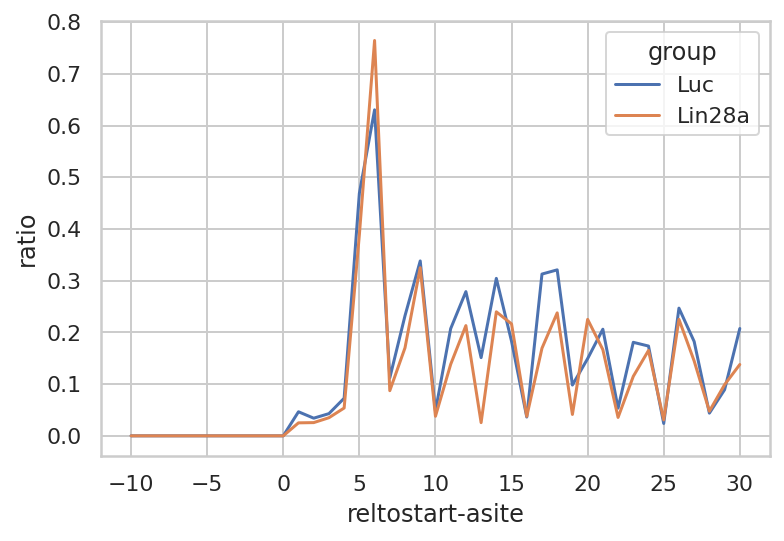

In [97]:
target_range=range(-10,31)
siLin28a_start = siLin28a_df.loc[siLin28a_df['reltostart-asite'].isin(target_range)]
siLuc_start = siLuc_df.loc[siLuc_df['reltostart-asite'].isin(target_range)]
siLin28a_start = siLin28a_start[['transcript_id','reltostart-asite','rpm_ratio']].set_index(['transcript_id','reltostart-asite'])
siLuc_start = siLuc_start[['transcript_id','reltostart-asite','rpm_ratio']].set_index(['transcript_id','reltostart-asite'])

siLuc_start = siLuc_start.reindex(pd.MultiIndex.from_product([siLuc_start.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostart-asite'])).fillna(0)
siLin28a_start = siLin28a_start.reindex(pd.MultiIndex.from_product([siLin28a_start.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostart-asite'])).fillna(0)

siLuc_start = siLuc_start.groupby('reltostart-asite').mean()[['rpm_ratio']]
siLin28a_start = siLin28a_start.groupby('reltostart-asite').mean()[['rpm_ratio']]

stop_merge = pd.merge(siLuc_start, siLin28a_start, on='reltostart-asite', how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
stop_merge.columns = ['reltostart-asite','group','ratio']
stop_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['Luc','Lin28a'], inplace=True)
sns.lineplot(data=stop_merge, x='reltostart-asite', y='ratio', hue='group')

<AxesSubplot:xlabel='reltostop-asite', ylabel='ratio'>

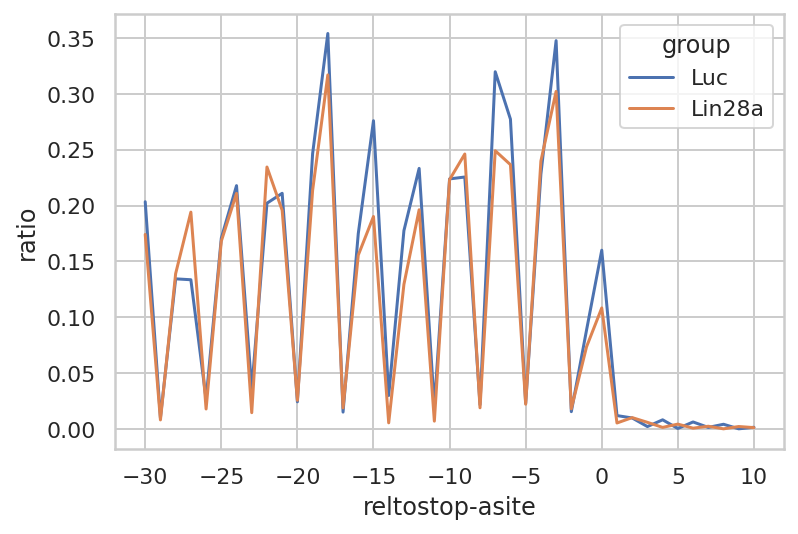

In [98]:
target_range = range(-30,11)
siLin28a_stop = siLin28a_df.loc[siLin28a_df['reltostop-asite'].isin(target_range)]
siLuc_stop = siLuc_df.loc[siLuc_df['reltostop-asite'].isin(target_range)]
siLin28a_stop = siLin28a_stop[['transcript_id','reltostop-asite','rpm_ratio']].set_index(['transcript_id','reltostop-asite'])
siLuc_stop = siLuc_stop[['transcript_id','reltostop-asite','rpm_ratio']].set_index(['transcript_id','reltostop-asite'])

siLuc_stop = siLuc_stop.reindex(pd.MultiIndex.from_product([siLuc_stop.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostop-asite'])).fillna(0)
siLin28a_stop = siLin28a_stop.reindex(pd.MultiIndex.from_product([siLin28a_stop.index.get_level_values('transcript_id'),target_range], names=['transcript_id','reltostop-asite'])).fillna(0)

siLuc_stop = siLuc_stop.groupby('reltostop-asite').mean()[['rpm_ratio']]
siLin28a_stop = siLin28a_stop.groupby('reltostop-asite').mean()[['rpm_ratio']]

stop_merge = pd.merge(siLuc_stop, siLin28a_stop, on='reltostop-asite', how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
stop_merge.columns = ['reltostop-asite','group','ratio']
stop_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['Luc','Lin28a'], inplace=True)
sns.lineplot(data=stop_merge, x='reltostop-asite', y='ratio', hue='group')

Lin28a binding motif가 CDS에 있어서 translation inhibition을 발생시켰다면, stop codon때 붙는 ratio가 감소해야하는데, 그렇지 않음.
따라서 CDS지역에서 rpf stalling과 같은 현상에 의한것이 아닐 가능성이 있음.

# TMD와 주변에서 RPF binding이 바뀌는지 확인

In [99]:
siLuc_df = select_highly_expressing_genes('siLuc_transcriptome.bed')
siLuc_trans = get_transmem_dist(siLuc_df, Dist)
siLuc_count = trans_typing(siLuc_trans, ratio=False)
siLuc_ratio = trans_typing(siLuc_trans, ratio=True)
siLuc_ratio.head()

/tmp/ipykernel_1085848/4057274380.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
/tmp/ipykernel_1085848/4057274380.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio / df_ratio.sum(level='gene_id')


,gene_id,trans_type,region,ratio
0,ENSMUSG00000006445,N-term signal,Downstream,0.261484
1,ENSMUSG00000006445,N-term signal,TMD,0.434629
2,ENSMUSG00000006445,N-term signal,Upstream,0.303887
3,ENSMUSG00000007458,N-term signal,Downstream,0.419872
4,ENSMUSG00000007458,N-term signal,TMD,0.327724


In [100]:
siLin28a_df = select_highly_expressing_genes('siLin28a_transcriptome.bed')
siLin28a_trans = get_transmem_dist(siLin28a_df, Dist)
siLin28a_count = trans_typing(siLin28a_trans, ratio = False)
siLin28a_ratio = trans_typing(siLin28a_trans, ratio = True)

siLin28a_ratio 

/tmp/ipykernel_1085848/4057274380.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
/tmp/ipykernel_1085848/4057274380.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio / df_ratio.sum(level='gene_id')


,gene_id,trans_type,region,ratio
0,ENSMUSG00000005672,N-term signal,Downstream,0.296078
1,ENSMUSG00000005672,N-term signal,TMD,0.443137
2,ENSMUSG00000005672,N-term signal,Upstream,0.260784
3,ENSMUSG00000006445,N-term signal,Downstream,0.229814
4,ENSMUSG00000006445,N-term signal,TMD,0.427684
...,...,...,...,...
224,ENSMUSG00000070394,Multi-pass,TMD,0.567883
225,ENSMUSG00000070394,Multi-pass,Upstream,0.106569
226,ENSMUSG00000078681,Multi-pass,Downstream,0.102655
227,ENSMUSG00000078681,Multi-pass,TMD,0.355752


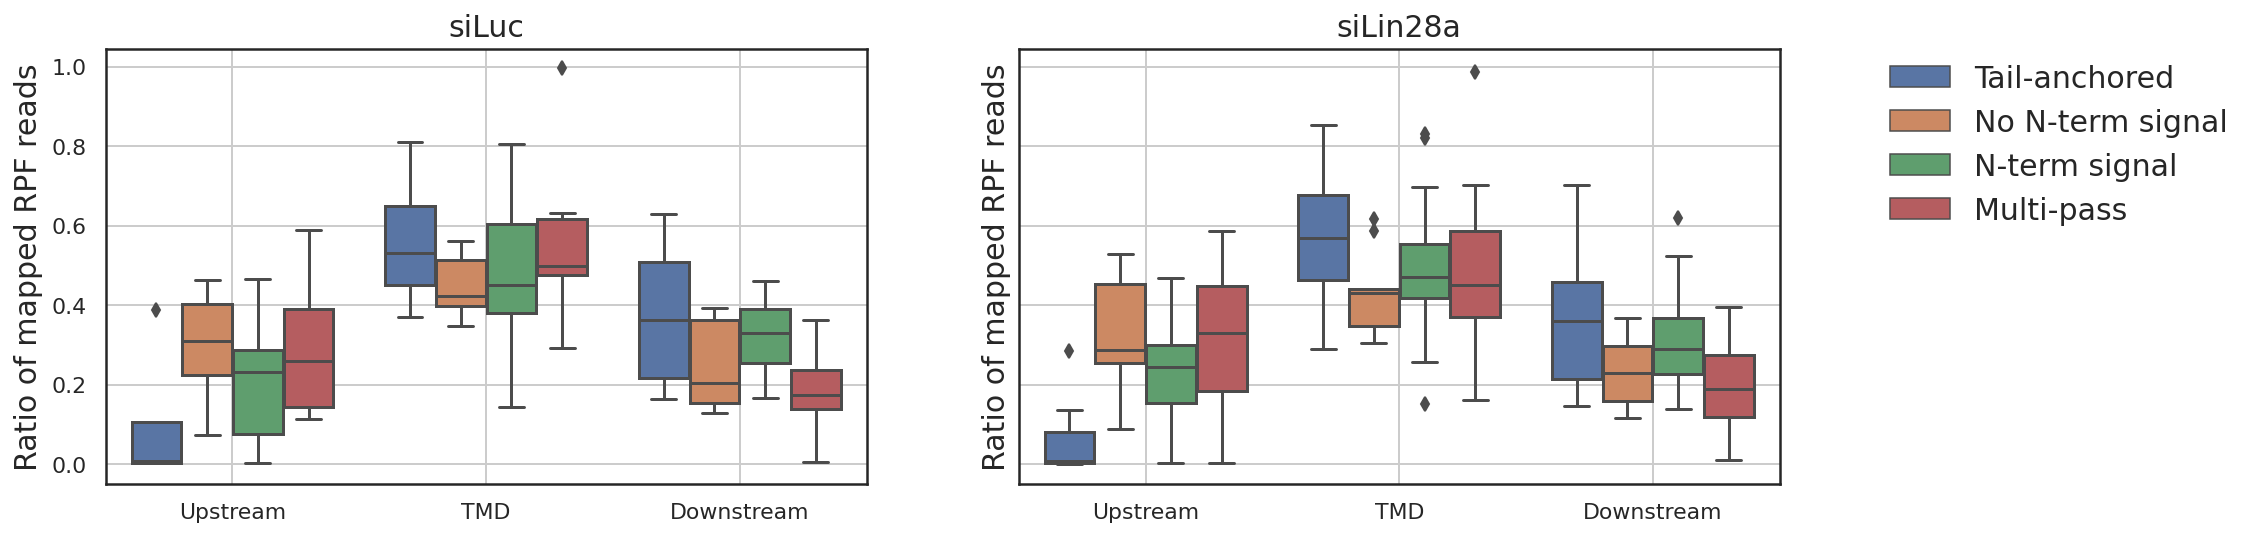

In [105]:
sns.set_theme(style='white')
fig, ax = plt.subplots(1,2, figsize=(15, 4), sharey=True)
title_list = ['siLuc','siLin28a']
for num, df in enumerate([siLuc_ratio, siLin28a_ratio]):
    g = sns.boxplot(data=df, x='region', y='ratio',hue='trans_type', order=['Upstream','TMD','Downstream'], hue_order = ['Tail-anchored','No N-term signal','N-term signal','Multi-pass'], ax=ax[num])
    g.set_title(title_list[num], fontsize=15)
    g.legend([],[], frameon=False)
    handles, labels = plt.gca().get_legend_handles_labels()
    g.grid()
    g.set_xlabel('')
    g.set_ylabel('Ratio of mapped RPF reads', fontsize=15)
    fig.legend(handles[:], labels[:], bbox_to_anchor=(1.12,0.9), fontsize=15, ncol=1,frameon=False)